Dimer with Kanamori interaction
=======

We calculate the Green function of a dimer coupled with Kanamori interaction and a coupling to discrete bath states.

The non-interacting hamiltonian is most conveniently expressed using a matrix representation

$$
\hat{h} =
\begin{pmatrix}
\hat{h}_{0} & \hat{h}_{\rm coup} \\
\hat{h}_{\rm coup} & \hat{h}_{\rm bath}  \\
\end{pmatrix}=
\begin{pmatrix}
\begin{pmatrix}
\epsilon_0 -\mu & -t \\
-t & \epsilon_1 -\mu
\end{pmatrix} & 
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
\\
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix} & 
\begin{pmatrix}
\epsilon_{0,{\rm bath}} & -t_{\rm bath} \\
-t_{\rm bath} & \epsilon_{1,{\rm bath}}
\end{pmatrix}
\end{pmatrix}
$$

The impurity interaction is of the Kanamori-type, and reads

$$h_{\rm int} = \sum_{i,j} U n_{\uparrow,i} n_{\downarrow,j} + \sum_{\sigma,i\neq j} U' n_{\sigma,i} n_{\sigma,j}
            - \sum_{i \neq j} J c^\dagger_{i \uparrow} c_{i \downarrow} c^\dagger_{j \downarrow} c_{j \uparrow}
            + \sum_{i \neq j} J c^\dagger_{i \uparrow} c^\dagger_{i \downarrow} c_{j \downarrow} c_{j \uparrow}$$
   
The parameters are defined below.

In [1]:
# %load model.py
import sys, os
sys.path.append(os.getcwd() + '/../common')
from util import *

from pytriqs.gf import Gf, MeshImFreq, iOmega_n, inverse
from pytriqs.operators import c, c_dag, n
from pytriqs.operators.util.hamiltonians import h_int_kanamori
from itertools import product
from numpy import matrix, array, diag, eye
from numpy.linalg import inv

# ==== System Parameters ====
beta = 5.                       # Inverse temperature
mu = 0.0                        # Chemical potential
eps = array([0.0, 0.1])         # Impurity site energies
t = 0.2                         # Hopping between impurity sites

eps_bath = array([0.27, -0.4])  # Bath site energies
t_bath = 0.0                    # Hopping between bath sites

U = 2.                          # On-site interaction
V = 1.                          # Intersite interaction
J = 0.5                         # Hunds coupling

spin_names = ['up', 'dn']
orb_names  = [0, 1]

# Non-interacting impurity hamiltonian in matrix representation
h_0_mat = diag(eps - mu) - matrix([[0, t],
                                   [t, 0]])

# Bath hamiltonian in matrix representation
h_bath_mat = diag(eps_bath) - matrix([[0, t_bath],
                                      [t_bath, 0]])

# Coupling matrix
V_mat = matrix([[1., 1.],
                [1., 1.]])

# ==== Local Hamiltonian ====
c_dag_vec = { s: matrix([[c_dag(s,o) for o in orb_names]]) for s in spin_names }
c_vec =     { s: matrix([[c(s,o)] for o in orb_names]) for s in spin_names }

h_0 = sum(c_dag_vec[s] * h_0_mat * c_vec[s] for s in spin_names)[0,0]

h_int = h_int_kanamori(spin_names, orb_names,
                        array([[0,      V-J ],
                               [V-J   , 0   ]]), # Interaction for equal spins
                        array([[U,      V ],
                               [V,      U ]]),   # Interaction for opposite spins
                        J,True)

h_loc = h_0 + h_int

# ==== Bath & Coupling hamiltonian ====
orb_bath_names = ['b_' + str(o) for o in orb_names]
c_dag_bath_vec = { s: matrix([[c_dag(s, o) for o in orb_bath_names]]) for s in spin_names }
c_bath_vec =     { s: matrix([[c(s, o)] for o in orb_bath_names]) for s in spin_names }

h_bath = sum(c_dag_bath_vec[s] * h_bath_mat * c_bath_vec[s] for s in spin_names)[0,0]
h_coup = sum(c_dag_vec[s] * V_mat * c_bath_vec[s] + c_dag_bath_vec[s] * V_mat * c_vec[s] for s in spin_names)[0,0] # FIXME Adjoint

# ==== Total impurity hamiltonian ====
h_imp = h_loc + h_coup + h_bath

# ==== Green function structure ====
gf_struct = [ [s, orb_names] for s in spin_names ]

# ==== Hybridization Function ====
n_iw = int(10 * beta)
iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
Delta = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)
# FIXME Delta['up'] << V_mat * inverse(iOmega_n - h_bath_mat) * V_mat.transpose()
for bl, iw in product(spin_names, iw_mesh):
    Delta[bl][iw] = V_mat * inv(iw.value * eye(len(orb_names)) - h_bath_mat) * V_mat.transpose()

# ==== Non-Interacting Impurity Green function  ====
G0_iw = Delta.copy()
G0_iw['up'] << inverse(iOmega_n - h_0_mat - Delta['up']) # FIXME Should work for BlockGf
G0_iw['dn'] << inverse(iOmega_n - h_0_mat - Delta['dn'])


Starting run with 1 MPI threads at : 2019-02-14 08:30:58.402213


Green Function G_dn with mesh Matsubara Freq Mesh of size 100, Domain: Matsubara domain with beta = 5, statistic = Fermion, positive_only : 0 and target_rank 2: 

Results
====

In [2]:
from pytriqs.plot.mpl_interface import oplot, plt
%matplotlib inline

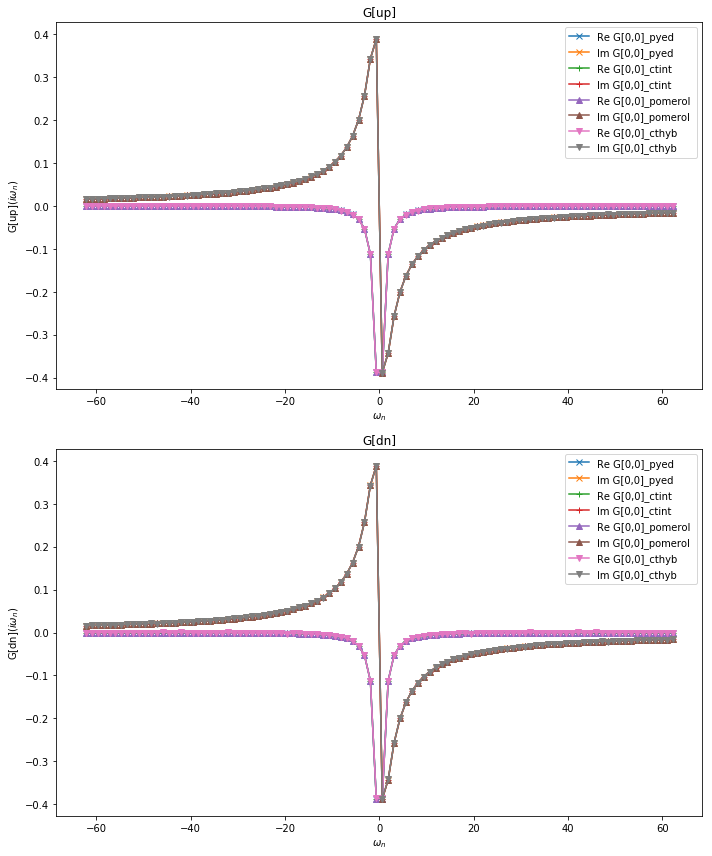

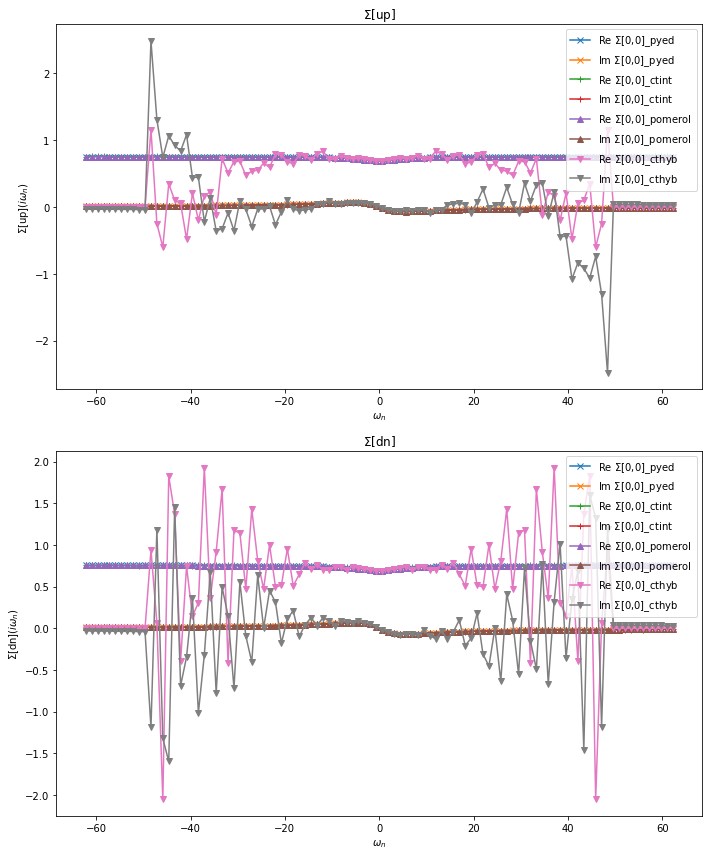

In [3]:
# %load ../common/plot.py
import sys, os
sys.path.append(os.getcwd() + "/..")
sys.path.append(os.getcwd() + "/../../common")
from model import *

from pytriqs.archive import HDFArchive
from pytriqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

# === Load Green function for every solver and calculate self-energy

solver_lst = [ basename(f).strip('.h5') for f in glob('results/*.h5') ]
marker_lst = ['-x', '-+', '-^', '-v', '-<', '->', '-*', '-p']
G, Sigma = {}, {}

for solver in solver_lst:
    dat = HDFArchive('results/' + solver + '.h5','r')
    G[solver] = dat['G']
    Sigma[solver] = G0_iw.copy()
    Sigma[solver] << inverse(G0_iw) - inverse(G[solver])

# === For every block and solver, plot Green function and Self energy

block_lst = list(G[solver_lst[0]].indices)
n_blocks = len(block_lst)

for g, name in [[G, 'G'], [Sigma, '$\Sigma$']]:

    plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

    for i, block in enumerate(block_lst,1):
        fig = plt.subplot(n_blocks,1,i)
        fig.set_title(name + "[" + block + "]")
        for solver in solver_lst:
            marker = marker_lst[solver_lst.index(solver)]
            oplot(g[solver][block][0,0], marker, name = name + "[0,0]_%s" % solver)
        plt.xlabel("$\omega_n$")
        plt.ylabel(name + "[" + block + "]$(i\omega_n)$")

    plt.tight_layout()
    plt.show()


Deviations
======

We present a table containing deviations between the different solvers measured via

$$||G_{\rm Solver_1} - G_{\rm Solver_2}||_\infty$$

In [4]:
import numpy as np

for block in block_lst:
    deviations = [[ np.amax(np.abs(G[s1][block].data - G[s2][block].data)) for s1 in solver_lst ] \
                    for s2 in solver_lst ]
    
    print "\t\t    Deviations for Block " + block
    print "\t\t -----------------------------------"

    row_format ="{:>15}" * (len(solver_lst) + 1)
    print row_format.format("", *solver_lst)
    row_format ="{:>15}" + "{:>15.2E}" * len(solver_lst)
    for solver, row in zip(solver_lst, deviations):
        print row_format.format(solver, *row)
        
    print "\n\n"

		    Deviations for Block up
		 -----------------------------------
                          pyed          ctint        pomerol          cthyb
           pyed       0.00E+00       1.02E-04       1.89E-07       1.02E-03
          ctint       1.02E-04       0.00E+00       1.02E-04       1.02E-03
        pomerol       1.89E-07       1.02E-04       0.00E+00       1.02E-03
          cthyb       1.02E-03       1.02E-03       1.02E-03       0.00E+00



		    Deviations for Block dn
		 -----------------------------------
                          pyed          ctint        pomerol          cthyb
           pyed       0.00E+00       2.94E-04       1.89E-07       2.05E-03
          ctint       2.94E-04       0.00E+00       2.94E-04       2.05E-03
        pomerol       1.89E-07       2.94E-04       0.00E+00       2.05E-03
          cthyb       2.05E-03       2.05E-03       2.05E-03       0.00E+00



